In [224]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images


In [225]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


## UNet-Model

In [226]:
# model_cnn = tf.keras.models.load_model("./models/single_rgb_image")


In [227]:
# img1 = Image.open(
#     "D:\Main\MA_PROGR\Data\Train\LED_Wand_Aufnahmen\Alias\LED_Wand_20001.png")
# img1 = np.asarray(img1)/255
# img1 = img1.reshape(1, 60, 60, 3)
# res1 = model.predict(img1)
# print(res1)


In [228]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [229]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [230]:
train_filmed_imgs = []
train_clean_imgs = []

In [231]:
OFFSET = 200

for addr_filmed in os.listdir(TRAIN_FILMED_PATH):
    img = plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
    train_filmed_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])

for addr_clean in os.listdir(TRAIN_CLEAN_PATH):
    img = plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
    train_clean_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])


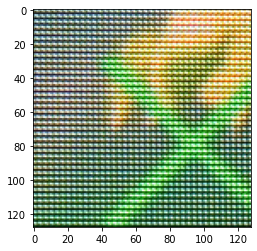

In [232]:
plt.imshow(train_filmed_imgs[0])
plt.show()


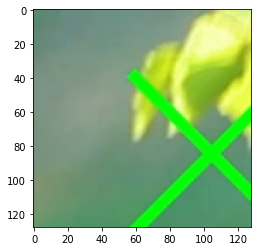

In [233]:
plt.imshow(train_clean_imgs[0])
plt.show()


## Build U-Net-Model

In [234]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), batch_size=None)

# Hier werden Preprocessing-Schritte ausgeführt
# s ist hier dann Differnzbild (Pixelraum_Fourier)
s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_u_net = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
model_u_net.summary()


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 128, 128, 1)  0           input_141[0][0]                  
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 128, 128, 16) 160         lambda_14[0][0]                  
__________________________________________________________________________________________________
dropout_126 (Dropout)           (None, 128, 128, 16) 0           conv2d_266[0][0]                 
___________________________________________________________________________________________

## Train Model

In [235]:
# ppm: postprocessing model 

def create_postprocessing_model():

    ppm_input_img_clean = tf.keras.Input(shape=(128,128, 3), batch_size=1)
    ppm_input_img_filmed = tf.keras.Input(shape=(128,128, 3), batch_size=1)
    ppm_input_unet_output = tf.keras.Input(shape=(128,128), batch_size=1)

    ppm_input_img_clean_complex_r = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_g = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_b = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)

    ppm_input_img_filmed_complex_r = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_g = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_b = tf.keras.Input(shape=(128,128), batch_size=1, dtype=tf.complex64)



    ones = tf.ones((128, 128))
    zeros = tf.zeros((128, 128))
    ones_t2c = tf.complex(ones, zeros)
    u_net_output_t2c = tf.complex(ppm_input_unet_output, zeros)

    # FORMEL: (1 - out) * clean + out * filmed
    # out == mask 
    # t2c -> transfered to complex


    def soft_blending(clean, filmed, ones_t2c=ones_t2c, u_net_output_t2c=u_net_output_t2c):
        zw1 = tf.math.subtract(ones_t2c, u_net_output_t2c)
        zw1 = tf.math.multiply(zw1, clean)

        zw2 = tf.multiply(u_net_output_t2c, filmed)
        return tf.math.add(zw1, zw2)


    img_processed_complex_fourier_r = soft_blending(
        ppm_input_img_clean_complex_r, ppm_input_img_filmed_complex_r)

    img_processed_complex_fourier_g = soft_blending(
        ppm_input_img_clean_complex_g, ppm_input_img_filmed_complex_g)

    img_processed_complex_fourier_b = soft_blending(
        ppm_input_img_clean_complex_b, ppm_input_img_filmed_complex_b)



    # # img_processed_px_fourier = tf.math.log(                     # zum anschauen
    # #     tf.math.abs(img_processed_complex_fourier_r))

    # ----------- INVERSE FOURIER TRANSFORMATION -----------

    img_processed_r = tf.signal.ifft2d(
        img_processed_complex_fourier_r
    )
    img_processed_g = tf.signal.ifft2d(
        img_processed_complex_fourier_g
    )
    img_processed_b = tf.signal.ifft2d(
        img_processed_complex_fourier_b
    )


    # 3 Einzelkanäle zu einem RGB Bild
    img_processed_r = tf.math.abs(img_processed_r)/255
    img_processed_g = tf.math.abs(img_processed_g)/255
    img_processed_b = tf.math.abs(img_processed_b)/255

    img_processed_rgb = tf.stack(
        [img_processed_r, img_processed_g, img_processed_b], axis=3)

    postprocess_model = tf.keras.Model(inputs=[
        ppm_input_img_clean, 
        ppm_input_img_filmed,
        ppm_input_unet_output,
        ppm_input_img_clean_complex_r ,
        ppm_input_img_clean_complex_g ,
        ppm_input_img_clean_complex_b ,
        ppm_input_img_filmed_complex_r, 
        ppm_input_img_filmed_complex_g,
        ppm_input_img_filmed_complex_b
    ], outputs=[img_processed_rgb], name="postprocessing_model")

    # postprocess_model.summary()
    return postprocess_model


In [236]:
# def create_postprocessing_model():
#     clean = tf.keras.Input(shape=(128, 128, 3), batch_size=1)
#     darker = tf.math.multiply(clean, 3)

#     postprocessing_model = tf.keras.Model(inputs=[clean], outputs=[darker])

#     return postprocessing_model


In [237]:
postprocessing_model = create_postprocessing_model()
postprocessing_model.summary()


Model: "postprocessing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_144 (InputLayer)          [(1, 128, 128)]      0                                            
__________________________________________________________________________________________________
tf.dtypes.complex_14 (TFOpLambd (1, 128, 128)        0           input_144[0][0]                  
__________________________________________________________________________________________________
tf.math.subtract_42 (TFOpLambda (1, 128, 128)        0           tf.dtypes.complex_14[0][0]       
__________________________________________________________________________________________________
input_145 (InputLayer)          [(1, 128, 128)]      0                                            
_______________________________________________________________________________

## Custom Train loop


In [238]:
# Custom train loop

show_intermediate_pics = False

RGB_WEIGHTS = [0.299, 0.587, 0.114]


train_loss_results = []
train_accuracy_results = []


execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 3
batch_size_cnn = 1
batch_size_unet = 3

optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.MeanAbsoluteError()
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
epoch_loss = tf.keras.metrics.MeanAbsoluteError()
# epoch_loss = tf.keras.metrics.SparseCategoricalAccuracy()
# epoch_loss = tf.keras.metrics.SparseCategoricalCrossentropy()

train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")


for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in range(batch_size_unet):
        print("next batch...")

        with tf.GradientTape() as tape:

            cnn_mean_prediction_values = []
            del cnn_mean_prediction_values [:]


            # X_train: müsste bei mir ein Iterator sein, welcher 1 Bild zurückgibt (1, 128, 128, 3)
        
            # Bilder für den nächsten Batch sammeln:
            for x_filmed, x_clean in tqdm(zip(train_filmed_imgs, train_clean_imgs), desc="training...", ascii=False, ncols=75):
                print("next image...")


                # ---- Preprocessing mit Python ----


                if show_intermediate_pics:
                    print("######################### Train step #################################")

                fourier_handler = Fourier_Images(x_filmed, x_clean)

                img_filmed_r, img_filmed_g, img_filmed_b = fourier_handler.split_RGB_2_Grayscale(
                    x_filmed)
                img_clean_r, img_clean_g, img_clean_b = fourier_handler.split_RGB_2_Grayscale(
                    x_clean)

                img_filmed_complex_r = fourier_handler.grayscale_2_Fourier(
                    img_filmed_r)
                img_filmed_complex_g = fourier_handler.grayscale_2_Fourier(
                    img_filmed_g)
                img_filmed_complex_b = fourier_handler.grayscale_2_Fourier(
                    img_filmed_b)

                img_clean_complex_r = fourier_handler.grayscale_2_Fourier(
                    img_clean_r)
                img_clean_complex_g = fourier_handler.grayscale_2_Fourier(
                    img_clean_g)
                img_clean_complex_b = fourier_handler.grayscale_2_Fourier(
                    img_clean_b)


                x_filmed_fourier_px, x_clean_fourier_px, differenzbild_fourier_px, img_filmed_fourier_combined, img_clean_fourier_combined = fourier_handler.generate_mask_from_images()
                # plt.imsave(".\\tmp\\img_filmed_fourier_combined.png",
                #            img_filmed_fourier_combined, cmap="gray")
                # plt.imsave(".\\tmp\\img_clean_fourier_combined.png",
                #            img_clean_fourier_combined, cmap="gray")
                if show_intermediate_pics:
                    print("differenzbild_fourier_px: ")
                    # print(differenzbild_fourier_px)
                    plt.imshow(differenzbild_fourier_px, cmap="gray")
                    plt.show()
                differenzbild_fourier_px = differenzbild_fourier_px.reshape(
                    1, IMG_WIDTH, IMG_HEIGHT, 1)



                del(fourier_handler)



                # ----------- HIER STARTET U-NET-MODEL -----------

                u_net_output = execute_UNet_model(
                    differenzbild_fourier_px, training=True)

                # print("u_net_output: ")
                # print(u_net_output)

                # ----------- ALPHA-BLENDING -----------


                # CASTING IST NICHT ABLEITBAR - KANN MAN NICHT VERWENDEN!!
                # u_net_output = tf.cast(u_net_output, tf.int32)
                # u_net_output = tf.cast(u_net_output, tf.bool)

                # FORMEL: (1 - out) * clean + out * filmed
                # t2c -> transfered to complex


                if show_intermediate_pics:
                    print("x_clean: ")
                    plt.imshow(x_clean)
                    plt.show()

                    print("x_filmed: ")
                    plt.imshow(x_filmed)
                    plt.show()

                x_clean = x_clean.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
                x_filmed = x_filmed.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))



                u_net_output = tf.reshape(
                    u_net_output, shape=(IMG_WIDTH, IMG_HEIGHT))

                img_clean_complex_r = img_clean_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
                img_clean_complex_g = img_clean_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
                img_clean_complex_b = img_clean_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
                img_filmed_complex_r = img_filmed_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
                img_filmed_complex_g = img_filmed_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
                img_filmed_complex_b = img_filmed_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

                # ------------ postprocessing Model aufrufen --------

                image_processed_rgb = execute_postprocessing_model([
                    x_clean ,
                    x_filmed ,
                    u_net_output,
                    img_clean_complex_r ,
                    img_clean_complex_g ,
                    img_clean_complex_b ,
                    img_filmed_complex_r ,
                    img_filmed_complex_g ,
                    img_filmed_complex_b ,
                ])





                if show_intermediate_pics:
                    print("image_processed_rgb: ")
                    # print(np.array(image_processed_rgb).reshape(IMG_HEIGHT, IMG_WIDTH, 3))
                    plt.imshow(np.array(image_processed_rgb).reshape(
                        IMG_HEIGHT, IMG_WIDTH, 3))
                    plt.show()


                # ----------- Feed multiple Buckets in CNN for predicting amount of alias -----------

                def create_multiple_buckets_to_feed_them_into_CNN(tensor):

                    BATCH_SIZE_CNN = 1
                    NUM_BOXES = 30
                    CROP_SIZE = (60, 60)

                    boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
                    box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                                    maxval=BATCH_SIZE_CNN, dtype=tf.int32)
                    
                    output = tf.image.crop_and_resize(
                        tensor, boxes, box_indices, CROP_SIZE)
                    return output

                cnn_input = create_multiple_buckets_to_feed_them_into_CNN(image_processed_rgb)

                # print("cnn_input: ")
                # print(cnn_input)



                # ------- Make prediction --------

                y_pred = execute_cnn_model(cnn_input)

                y_pred = tf.math.reduce_mean(
                    y_pred, keepdims=True
                )

                cnn_mean_prediction_values.append(y_pred)

                # print("cnn_mean_prediction_values: ")
                # print(cnn_mean_prediction_values)

            
                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------



            # ----------- Calc loss -----------

            y_true = tf.zeros(batch_size_unet, 1)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)
            # print("loss: ")
            # print(loss)

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)


            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")



            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1
        
        # End Epoch
        train_accuracy_results.append(epoch_loss.result())
        print(f"--------------- epoch_loss: {epoch_loss.result()}")



overall_train_loss = epoch_loss.result()
print(f"overall_train_loss: {overall_train_loss}")
epoch_loss.reset_states()


Start of epoch 0
next batch...


training...: 0it [00:00, ?it/s]

next image...


training...: 2it [00:01,  1.97it/s]

next image...
next image...


training...: 4it [00:01,  3.41it/s]

next image...


training...: 5it [00:01,  3.94it/s]

next image...


training...: 5it [00:01,  2.90it/s]


--------------- epoch_loss: 0.1571936458349228
next batch...


training...: 1it [00:00,  6.03it/s]

next image...
next image...


training...: 3it [00:00,  5.98it/s]

next image...
next image...


training...: 5it [00:00,  5.96it/s]


next image...
--------------- epoch_loss: 0.14980484545230865
next batch...


training...: 1it [00:00,  5.76it/s]

next image...


training...: 2it [00:00,  6.02it/s]

next image...
next image...


training...: 4it [00:00,  5.70it/s]

next image...
next image...


training...: 5it [00:00,  5.79it/s]


--------------- epoch_loss: 0.13219229876995087
Start of epoch 1
next batch...


training...: 1it [00:00,  6.03it/s]

next image...
next image...


training...: 3it [00:00,  5.76it/s]

next image...
next image...


training...: 5it [00:00,  5.57it/s]


next image...
--------------- epoch_loss: 0.13501586019992828
next batch...


training...: 1it [00:00,  6.14it/s]

next image...
next image...


training...: 3it [00:00,  5.51it/s]

next image...


training...: 4it [00:00,  5.40it/s]

next image...


training...: 5it [00:00,  5.52it/s]


next image...
--------------- epoch_loss: 0.13519592583179474
next batch...


training...: 1it [00:00,  6.17it/s]

next image...
next image...


training...: 3it [00:00,  6.02it/s]

next image...
next image...


training...: 5it [00:00,  5.78it/s]


next image...
--------------- epoch_loss: 0.133695587515831
Start of epoch 2
next batch...


training...: 1it [00:00,  5.09it/s]

next image...


training...: 2it [00:00,  5.50it/s]

next image...
next image...


training...: 4it [00:00,  5.76it/s]

next image...
next image...


training...: 5it [00:00,  5.57it/s]


--------------- epoch_loss: 0.11893510073423386
next batch...


training...: 1it [00:00,  6.09it/s]

next image...
next image...


training...: 3it [00:00,  6.14it/s]

next image...
next image...


training...: 5it [00:00,  5.86it/s]

next image...


--------------- epoch_loss: 0.10892230272293091
next batch...


training...: 1it [00:00,  6.15it/s]

next image...
next image...


training...: 2it [00:00,  6.05it/s]

next image...


training...: 4it [00:00,  5.20it/s]

next image...


training...: 5it [00:00,  5.49it/s]


next image...
--------------- epoch_loss: 0.10424377769231796
overall_train_loss: 0.10424377769231796


In [239]:
test_img = img[400:528, 400:528,:]
test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# plt.imshow(test_img)

test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

test_img


<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[136., 173., 139.],
         [136., 173., 139.],
         [135., 173., 139.],
         ...,
         [134., 176., 140.],
         [135., 177., 141.],
         [135., 178., 141.]],

        [[135., 173., 138.],
         [135., 173., 138.],
         [135., 173., 138.],
         ...,
         [135., 177., 140.],
         [135., 177., 140.],
         [135., 177., 140.]],

        [[134., 173., 137.],
         [134., 173., 137.],
         [134., 173., 137.],
         ...,
         [135., 177., 140.],
         [135., 177., 140.],
         [135., 177., 140.]],

        ...,

        [[133., 177., 151.],
         [133., 177., 150.],
         [133., 177., 149.],
         ...,
         [137., 187., 152.],
         [138., 187., 152.],
         [138., 187., 151.]],

        [[133., 177., 151.],
         [133., 177., 150.],
         [133., 177., 149.],
         ...,
         [136., 188., 151.],
         [137., 187., 151.],
         

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


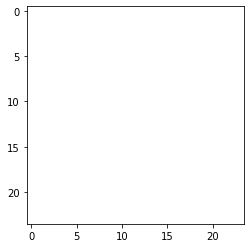

In [240]:
import tensorflow as tf
BATCH_SIZE = 1
NUM_BOXES = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 3
CROP_SIZE = (24, 24)

test_img = img[400:528, 400:528, :]
test_img = np.array(test_img).reshape(1, 128, 128, 3)

# plt.imshow(test_img)

test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
image = test_img
boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# plt.show()
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
output.shape  # => (5, 24, 24, 3)

plt.imshow(output[2])
